# install small text

In [1]:
%pip install small-text==1.3.0   

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 4.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
import logging
import datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from small_text import SklearnDataset, PoolBasedActiveLearner, PredictionEntropy, SklearnClassifierFactory, random_initialization_balanced
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from small_text import SklearnDataset

In [3]:
# Suppress warnings
warnings.filterwarnings('ignore')
datasets.logging.set_verbosity_error()

# Load Data

In [4]:
# Load the "imdb" dataset from the datasets library
raw_dataset = datasets.load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

# Extract text and label columns from the dataset


In [14]:
# Extract text and label columns from the dataset
X = raw_dataset['train']['text']
Y = raw_dataset['train']['label']
train = raw_dataset['train']
test = raw_dataset['test']

In [ ]:
Y

In [19]:
Y=np.array(Y)

In [22]:
np.sum(Y==0), np.sum(Y==1)

(12500, 12500)

# TF-IDF vectorizer

In [6]:
# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))

In [7]:
# Define the number of classes
num_classes = len(np.unique(Y))

In [9]:
num_classes, np.unique(Y)

(2, array([0, 1]))

In [8]:
target_labels = np.arange(num_classes)


train = SklearnDataset.from_arrays(np.array(train['text']),
                                        np.array(train['label']),
                                        vectorizer=vectorizer,
                                        target_labels=target_labels)

test = SklearnDataset.from_arrays(np.array(test['text']), 
                                       np.array(test['label']),
                                       vectorizer=vectorizer,
                                       target_labels=target_labels,
                                       train=False)

Train F1-score: 0.99
Test F1-score: 0.72
---------------
Iteration #0 (220 samples)
Train F1-score: 0.99
Test F1-score: 0.73
---------------
Iteration #1 (240 samples)
Train F1-score: 0.99
Test F1-score: 0.73
---------------
Iteration #2 (260 samples)
Train F1-score: 0.99
Test F1-score: 0.75
---------------
Iteration #3 (280 samples)
Train F1-score: 0.99
Test F1-score: 0.76
---------------
Iteration #4 (300 samples)
Train F1-score: 0.99
Test F1-score: 0.76
---------------
Iteration #5 (320 samples)
Train F1-score: 0.99
Test F1-score: 0.77
---------------
Iteration #6 (340 samples)
Train F1-score: 0.99
Test F1-score: 0.78
---------------
Iteration #7 (360 samples)
Train F1-score: 0.99
Test F1-score: 0.78
---------------
Iteration #8 (380 samples)
Train F1-score: 0.99
Test F1-score: 0.79
---------------
Iteration #9 (400 samples)
Train F1-score: 0.99
Test F1-score: 0.79
---------------
Iteration #10 (420 samples)
Train F1-score: 0.99
Test F1-score: 0.79
---------------
Iteration #11 (440

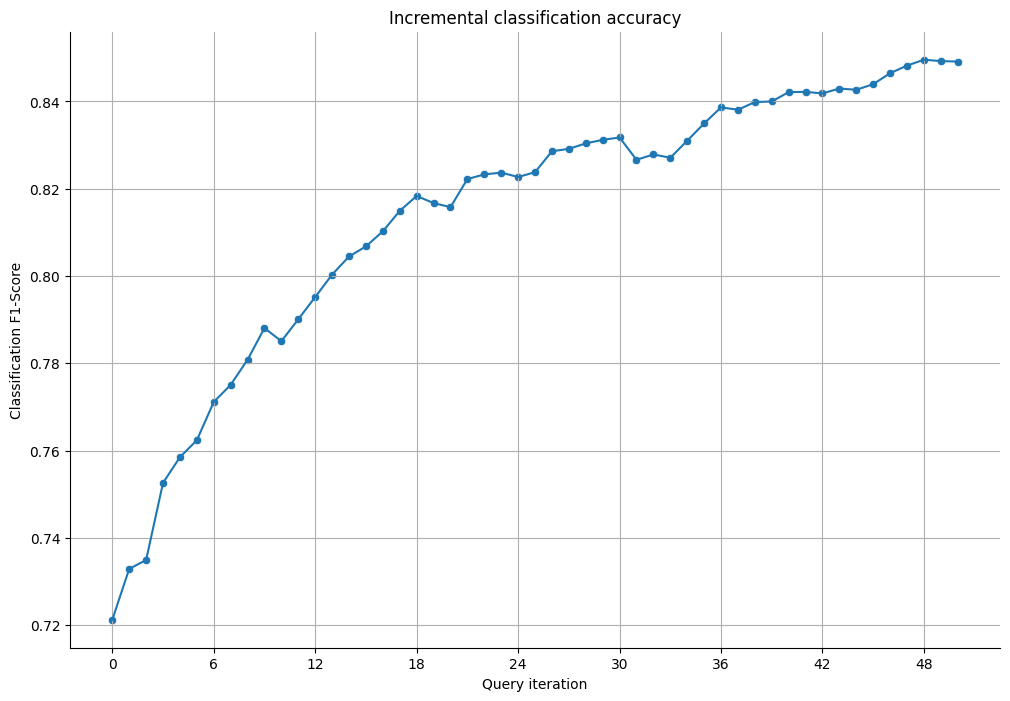

In [9]:
# Initialize the logistic regression model
seed = 2023
model = LogisticRegression(random_state=seed)
clf_factory = SklearnClassifierFactory(model, num_classes)

# Initialize the active learner with PredictionEntropy query strategy
query_strategy = PredictionEntropy()
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)

# Function to initialize the active learner
def initialize_active_learner(active_learner, y_train):
    indices_initial = random_initialization_balanced(y_train, n_samples=200)
    active_learner.initialize_data(indices_initial, y_train[indices_initial])
    return indices_initial

# Initialize the active learner
indices_labeled = initialize_active_learner(active_learner, train.y)

# Define the evaluation function
def evaluate(active_learner, train, test):
    y_pred_train = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    train_f1 = f1_score(train.y, y_pred_train,average='weighted')
    test_f1 = f1_score(test.y, y_pred_test,average='weighted')

    print('Train F1-score: {:.2f}'.format(train_f1))
    print('Test F1-score: {:.2f}'.format(test_f1))
    
    return test_f1

# Perform active learning iterations
num_queries = 50
results = []

results.append(evaluate(active_learner, train[indices_labeled], train))  # Using train set for initial evaluation

for i in range(num_queries):
    indices_queried = active_learner.query(num_samples=20)
    y = train.y[indices_queried]
    active_learner.update(y)
    indices_labeled = np.concatenate([indices_queried, indices_labeled])
    
    print('---------------')
    print(f'Iteration #{i} ({len(indices_labeled)} samples)')
    results.append(evaluate(active_learner, train[indices_labeled], train))

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.xaxis.set_major_locator(mtick.MaxNLocator(nbins=10, integer=True))
plt.grid()

data = np.vstack((np.arange(num_queries+1), np.array(results)))
sns.lineplot(x=0, y=1, data=data)
sns.scatterplot(x=0, y=1, data=data)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification F1-Score')
sns.despine()

plt.show()